# Week 3. Day 3. Exercises from Chapter 9 of FSStDS. 
## Fundamentals of Social Data Science. MT 2022

Within your study pod discuss the following questions. Please submit an individual assignment by 12:30pm Monday, October 31st🎃, 2022 on Canvas. 

# Telling a story using multiple distributions and multiple media 

In this exercise, you are asked to show several skills that signal an accumulation of knowledge about research design in social data science. 

We are not expecting a complex statistical analysis. In fact, the goal should be to determine a simple approach wherever possible. 

Tell a story about a current event that enables you to make use of:
- Two different platforms. The default would be Twitter and Reddit, but you can flex your API skills should you choose. 
- At least one means comparison test (e.g., t-test or ANOVA)
- At least one correlation (determining whether it makes sense in a parametric or nonparametric form), 
- At least one scatterplot,
- At least one faceted distributional graph, such as a boxplot or violin plot.

**Step 1**. Link the story you tell to an intuition from either past literature, other current events, or personal experience. Please write it in a formal manner regardless of how you derive your intuitions. 

> For example, as a really simple case, "While crypto continues its descent in value, some communities appear adamant that it will continue to accrue in value. I explore the popularity of two cryptocurrencies: Ethereum and Monero by looking at the most recent posts discussing these currencies on Twitter and Reddit. By comparing the frequency over time of the last mentions of either, we can get a sense of how popular these currencies are, as well as whether they appear to benefit from organic content or suffer from scams and bots." 

**Step 2**. Describe the data you are collecting to make the comparison or explore the issue. Indicate what data makes sense and for what purpose

> For example, for Twitter, I am using the recent search and collecting the 5000 most recent mentions of "ethereum" and "monero". For each of these, I will examine whether there is a link in the tweet and the amount of public engagement from the tweet. For Reddit, I will be complementing this with a similar search using `praw`. Note: More details might be useful in your work

**Step 3**. Report the observations and their distributions as well as any issues you have encountered with sample size.  This should include visual presentations of the distributions.

**Step 4**. Report any bivariate or multivariate comparisons. If you have a hypothesis, restate it here and consider it in relation to the tests. This can include visual elements such as a heatmap or trendline.

**Step 5**. Reflect on findings in relation to the intuition or research motivation. 

This set of steps is loosely based on the structure of a research paper. The reason that I assert it is loosely based is because here we have slightly lower (or perhaps different) expectations. 
- In a research paper, we would expect the motivations for the analysis to be primarily based on academic conversations and past research.
- We wouldn't necessarily prescribe specific analyses _a priori_ in a paper. 
- Instead of merely reflecting on the quality of the tests we would want to link specific details back to the literature review or motivating concerns more directly. 
- We would probably pay much more attention to sample size and coverage. Here I have have made no specific demands of coverage except 'large enough to detect a reasonable difference'.  

Notes: 
1. Be careful with the means comparison tests. They are more likely to be reasonable within platform (one query to another or one subreddit to another) than between platform. 
2. The emphasis here is on setting up the argument with data and examining the shape of that data. We should exercise caution on generalisibility. However, it is worth considering that at least superficially by collecting more than 100 tweets or posts. 
3. You can use another platform, but please use a hot API and not a prepared data dump. 
4. It is not assumed that someone reading this paper will be able to collect the same data as you, so segment your code in such a way that you download and collect a suitable sample and then in another part perform any relevant subsequent analyses. 

You can submit the data alongside the code then so that someone can reproduce the findings. Please note that actual tweet data can only be shared within class and any public archive of this work should exclude the tweet to be rehydrated as per Twitter's Developer Terms.   

There is no rubric for this exercise. It will be graded by the course instructor and given both small amounts of qualitative feedback and a grade out of 100 on the Oxford scale (that is where 50 is a pass, 65 is a strong pass, 70 is a distinction). It will be returned in one week from submission.

# Step 1. Set up the motivations
- Machine Learning language complexity: Twitter Versus 
- Research Question: Is there a difference in linguistic complexity between machine learning discussion on Twitter versus Reddit?

Twitter plays a crucial role in disseminating research findings (CITATION). This is despite some apparently counter-academic features, notably the 280 character limit, which intuitively should limit complex discourse. A platform that has the features that promote longer discussions is Reddit. Nevertheless, scientists seem to use Reddit more for public outreach through so-called AMAs (Ask Me Anything), rather than peer promotion (CITATION). 

These different considerations plausibly affects the linguistic complexity of the discourse on the two platforms. However, the directionality of the effect is hard to predict: does the more academic audience of Twitter outweigh the shorter format? Or does the long-form compatability of Reddit promote more long-form discourse? This project aims to find out. Through collecting machine learning research discussions on both Twitter and Reddit, I will analyse whether there exists a significant difference between the platforms. I will then discuss the limitations and opportunities of the analysis and to what extent it generalizes to other fields. 


# Step 2. Describe the data 
Before describing the data collection, I want to operationalise the central concept of "linguistic complexity". In general, I will take linguistic complexity to mean _readability_, which is a well-studied field (see CITATION). However, with study comes disagreement, which has lead to a plethora of readability formulas with differing complexity and purpose from the straightforward (and hilariously named) "Simple Measure of Gobbledygook" (CITATION) to more complex multivariate procedures like the Bormuth Formulas (CITATION). For the purpose of this study, I will use the Dale-Chall (CITATION) formula, which uses a combination of unfamiliar words and average sentence length. This captures two key factors of variance (CITATION) as well as being easy to implement through the [`py-readability-metrics`](https://github.com/cdimascio/py-readability-metrics#dale-chall-readability) library. 

Now I will turn to the data collection, starting with Twitter. For collecting the data, I will use the Twitter API V2 with academic access. This allows me to get a more complete picture than with standard access. The specific query will be tweets containing `#NeurIPS2022`. NeurIPS is one of the leading conferences within Machine Learning (CITATION). Many researchers publish so-called threads describing their research. To gain enough statistical power for measuring Dale-Chall readability, my unit of analysis will be these threads. I will identify these threads using the newly-added `conversation_id` as well as the regex pattern `\d+/` that is typically used to denote threads.

In [ ]:
import numpy as np

In [91]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from typing import Optional
from tqdm import tqdm
from pathlib import Path
from readability import Readability

def read_json(filepath: Path) -> dict:
    """Reads a JSON file and returns a dictionary"""
    with open(filepath, "r") as f:
        return json.load(f)

config = read_json(Path("../twitter_config.json"))
headers = {"Authorization": f"Bearer {config['bearer_token']}"}

twitter_query = '(#NeurIPS2022 OR #AAAI2022) -is:retweet'

tweet_fields = "author_id,created_at,text,public_metrics,conversation_id"

tweet_url = "https://api.twitter.com/2/tweets/search/all"
params = {"query": twitter_query, "tweet.fields": tweet_fields, "max_results": 500}

r = requests.get(tweet_url, headers=headers, params=params)


In [88]:
len(r.json()["data"])

357

In [138]:
def sum_public_metrics(tweet: dict) -> int:
    """Sums the public metrics of a tweet"""
    return sum(tweet["public_metrics"].values())



[6,
 6,
 56,
 22,
 19,
 0,
 4,
 10,
 2,
 10,
 0,
 16,
 0,
 47,
 2,
 1,
 6,
 122,
 28,
 58,
 13,
 14,
 26,
 0,
 107,
 16,
 0,
 3,
 9,
 16,
 89,
 3,
 25,
 11,
 20,
 54,
 114,
 16,
 6,
 90,
 11,
 13,
 39,
 22,
 132,
 202,
 10,
 31,
 30,
 48,
 6,
 4,
 3,
 288,
 60,
 37,
 288,
 1,
 1,
 1,
 1,
 2,
 25,
 120,
 1,
 68,
 3,
 70,
 6,
 4,
 101,
 19,
 5,
 4,
 7,
 15,
 17,
 16,
 2,
 34,
 2,
 9,
 35,
 14,
 0,
 48,
 16,
 86,
 2,
 37,
 116,
 80,
 19,
 11,
 3,
 1,
 2,
 23,
 406,
 44,
 46,
 59,
 52,
 33,
 22,
 53,
 13,
 41,
 2,
 9,
 7,
 51,
 7,
 200,
 6,
 1341,
 26,
 100,
 8,
 66,
 103,
 24,
 51,
 65,
 2,
 31,
 14,
 2,
 15,
 338,
 3,
 11,
 49,
 37,
 174,
 30,
 43,
 3,
 7,
 90,
 507,
 11,
 6,
 1,
 1,
 21,
 1,
 26,
 2,
 1,
 3,
 26,
 33,
 17,
 9,
 1,
 29,
 2,
 6,
 61,
 45,
 9,
 8,
 235,
 218,
 18,
 129,
 32,
 314,
 526,
 3,
 169,
 1,
 149,
 48,
 292,
 212,
 143,
 82,
 9,
 11,
 12,
 189,
 25,
 11,
 3,
 180,
 56,
 1,
 23,
 16,
 2,
 14,
 21,
 76,
 80,
 5,
 4,
 138,
 3,
 0,
 3,
 19,
 52,
 11,
 25,
 229,
 3,
 7

In [89]:
initial_df = pd.json_normalize(r.json()['data'])
unique_convo_ids = initial_df['conversation_id'].unique()
len(unique_convo_ids)

349

In [93]:
def scrape_thread(conversation_id: str, headers: dict, tweet_fields: str) -> Optional[dict]:
    """Scrapes a thread of tweets based on a conversation_id"""
    tweet_url = "https://api.twitter.com/2/tweets/search/all"
    params = {"query": f"conversation_id:{conversation_id}", "tweet.fields": tweet_fields, "max_results": 100}
    r = requests.get(tweet_url, headers=headers, params=params)
    r.raise_for_status()
    if "data" not in r.json():
        return None
    return r.json()



In [159]:
import re
import functools
from typing import Dict, List
from tqdm import tqdm

def remove_user_names(text: str) -> str:
    """Removes user names from a string"""
    return re.sub(r"@\w+", "", text)

def remove_urls(text: str) -> str:
    """Removes URLs from a string"""
    return re.sub(r"http\S+", "", text)

def remove_hashtags(text: str) -> str:
    """Removes hashtags from a string"""
    return re.sub(r"#\w+", "", text)

def compose(*funcs):
    """Composes functions"""
    def inner(arg):
        return functools.reduce(lambda x, f: f(x), funcs, arg)
    return inner

def clean_text(text: str) -> str:
    """Cleans text"""
    clean_func = compose(remove_user_names, remove_urls, remove_hashtags)
    return " ".join(clean_func(text).split())

def create_convo_text(convo: List[dict]) -> str:
    """Creates a string of all the tweets in a conversation"""
    joined_text = "\n".join([tweet["text"] for tweet in convo])
    return clean_text(joined_text)

def get_dale_chall(text: str) -> float:
    """Gets the Dale-Chall readability score"""
    return Readability(text).dale_chall().score

old_data = pd.read_csv("../data/long_ml_tweet_convos.csv")
unique_convo_ids = old_data['conversation_id'].unique()


convo_list = []
metric_list = []
conversation_ids = []
tweet_ids = []
for convo_id in tqdm(unique_convo_ids):
    raw_convo = scrape_thread(convo_id, headers, tweet_fields)
    if raw_convo is None:
        continue
    clean_convo = create_convo_text(raw_convo["data"])
    mean_convo_reach = np.mean([sum_public_metrics(tweet) for tweet in raw_convo["data"]])
    metric_list.append(mean_convo_reach)
    convo_list.append(clean_convo)
    conversation_ids.append(convo_id)
    tweet_ids.append([tweet["id"] for tweet in raw_convo["data"]])





  1%|▏         | 1/76 [00:06<08:20,  6.67s/it]


KeyboardInterrupt: 

In [145]:

tweet_convo_df = pd.DataFrame({"text": convo_list, "popularity_score": metric_list, "conversation_id": conversation_ids,})

In [157]:
tweet_convo_df["number_of_words"] = tweet_convo_df["text"].apply(lambda x: len(x.split()))
long_tweet_convos = tweet_convo_df[tweet_convo_df["number_of_words"] > 99]
long_tweet_convos["readability_score"] = long_tweet_convos["text"].apply(get_dale_chall)

C:\Users\jhr\AppData\Local\Temp\ipykernel_15168\4178981681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_tweet_convos["readability_score"] = long_tweet_convos["text"].apply(get_dale_chall)


In [151]:
long_tweet_convos.to_csv("../data/long_ml_tweet_convos.csv", index=False)

In [95]:
long_convos = [convo for convo in convo_list if len(convo.split()) > 99]

print(f"All convos: {len(convo_list)}\nLong convos: {len(long_convos)}")

All convos: 197
Long convos: 75


In [96]:
tweet_convo = pd.DataFrame({"text": long_convos})
tweet_convo["score"] = tweet_convo["text"].apply(get_dale_chall)


<AxesSubplot: ylabel='Frequency'>

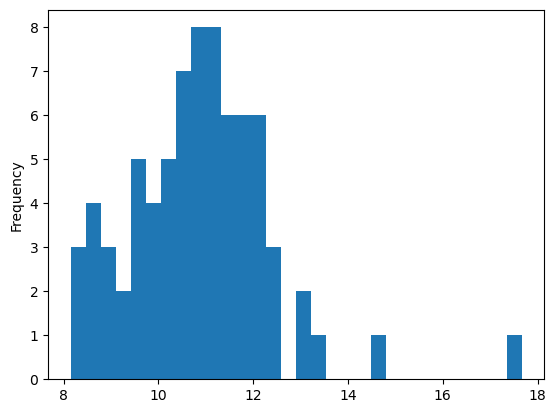

In [98]:
tweet_convo["score"].plot(kind="hist", bins=30)

For the Reddit data, I will scrape posts from the "r/MachineLearning" subreddit using [PRAW](LINK). I will focus on the comment sections of posts discussing research (denoted with an `[R]` tag in the title). I investigate comments rather than posts as many posts are simply links to articles or extracts from papers, which does not show Reddit-specific discourse. 

In [113]:
import praw

def comment_dict(comment: praw.models.Comment) -> dict:
    return {"body": comment.body, "id": comment.id, "parent_id": comment.parent_id, "score": comment.score}

reddit_config = read_json(Path("../reddit_config.json"))
reddit = praw.Reddit(client_id=reddit_config["client_id"],
                        client_secret=reddit_config["client_secret"],
                        user_agent="User: reddit-scraper by /u/RyzzleStrizzle")

subreddit = reddit.subreddit("MachineLearning")

reddit_convos = []
for submission in tqdm(subreddit.search("[R]", limit=100)):
    # remove comment limit
    submission.comments.replace_more(limit=None)
    for comment in submission.comments:
        if comment.is_root:
            convo = [comment_dict(comment)] + [comment_dict(reply) for reply in comment.replies]
            reddit_convos.append(convo)

100it [05:58,  3.58s/it]


In [118]:
clean_reddit_convos = [clean_text(" ".join(text["body"] for text in convo)) for convo in reddit_convos]
long_reddit_convos = [convo for convo in clean_reddit_convos if len(convo.split()) > 99]
len(long_reddit_convos)

114

In [123]:
import numpy as np
mean_convo_score = [np.mean([comment["score"] for comment in convo]) for convo in reddit_convos]
reddit_convo = pd.DataFrame({"text": clean_reddit_convos, "score": mean_convo_score})
reddit_convo["num_words"] = reddit_convo["text"].apply(lambda x: len(x.split()))
long_reddit_convos = reddit_convo[reddit_convo["num_words"] > 99]

In [124]:
long_reddit_convos["readability_score"] = long_reddit_convos["text"].apply(get_dale_chall)

C:\Users\jhr\AppData\Local\Temp\ipykernel_15168\1323066759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reddit_convos["readability_score"] = long_reddit_convos["text"].apply(get_dale_chall)


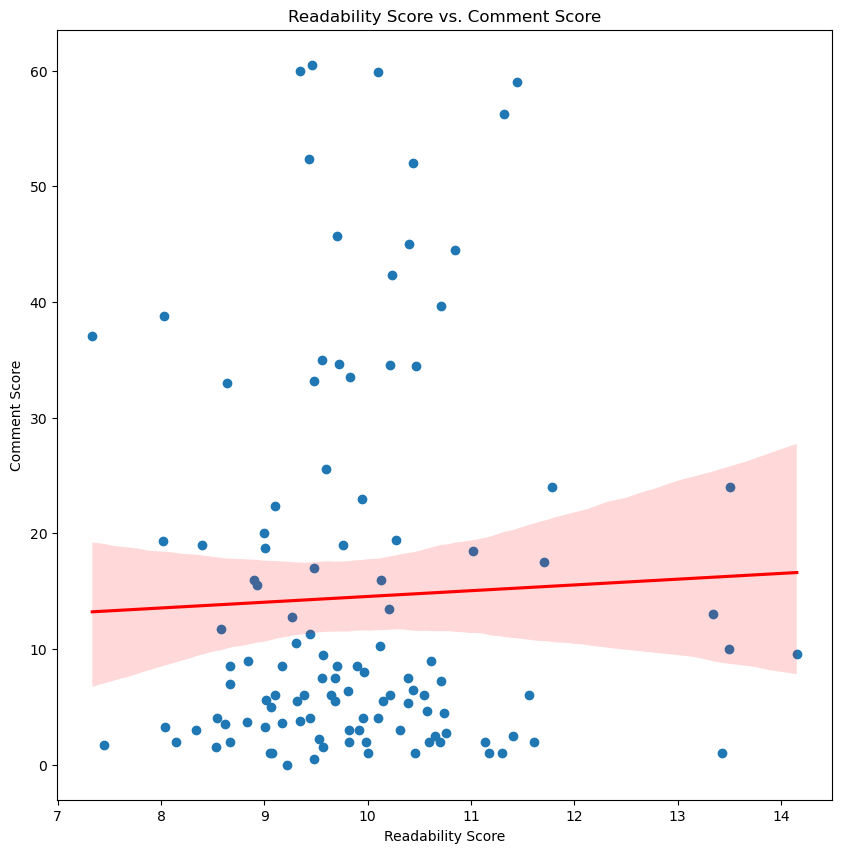

In [131]:
# Scatter plot of readability score vs. comment score
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(long_reddit_convos["readability_score"], long_reddit_convos["score"])
# add regression line with confidence interval
sns.regplot(x="readability_score", y="score", data=long_reddit_convos, ax=ax, scatter=False, color="red")
ax.set_xlabel("Readability Score")
ax.set_ylabel("Comment Score")
ax.set_title("Readability Score vs. Comment Score")
plt.show()

In [76]:
reddit_convo_df = pd.DataFrame({"text": long_reddit_convos})
reddit_convo_df["readability_score"] = reddit_convo_df["text"].apply(get_dale_chall)

In [132]:
long_reddit_convos.to_csv("../data/reddit_ml_convo.csv", index=False)
tweet_convo.to_csv("../data/twitter_ml_convo.csv", index=False)

# Step 3. Report the observations and their distributions
~~~
# Answer here. This might include figures as well as code and markdown
~~~

C:\Users\jhr\AppData\Local\Temp\ipykernel_15168\3746263552.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_tweet_convos["normalised_popularity"] = normalise_series(long_tweet_convos["popularity_score"])
C:\Users\jhr\AppData\Local\Temp\ipykernel_15168\3746263552.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reddit_convos["normalised_popularity"] = normalise_series(long_reddit_convos["score"])


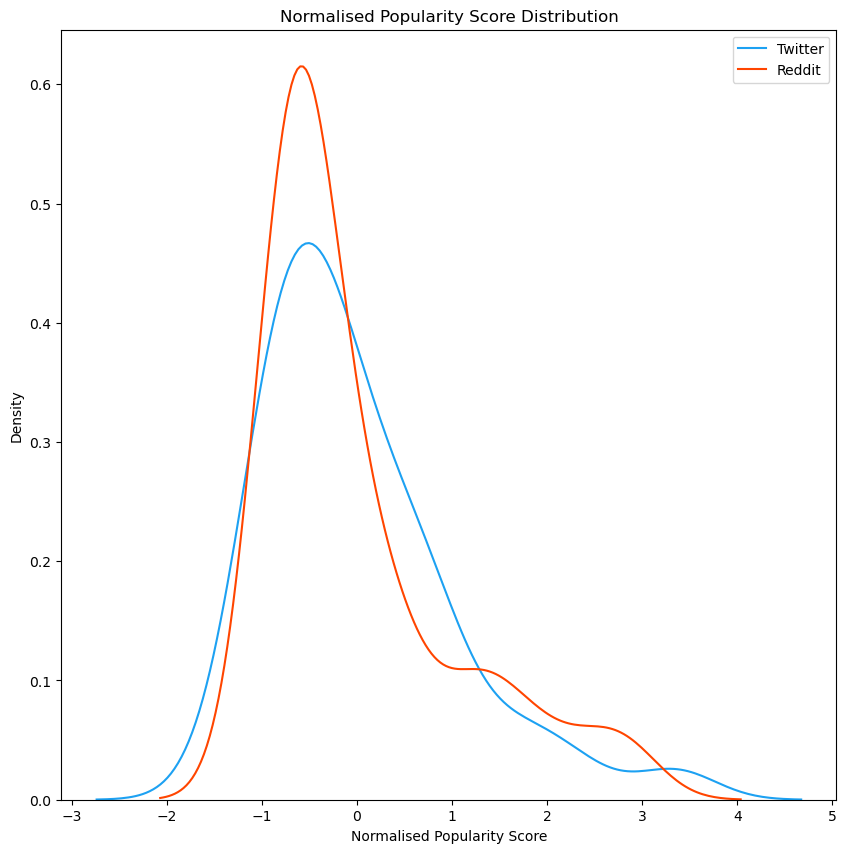

In [172]:
def normalise_series(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()


twitter_color = "#1DA1F2"
reddit_color = "#FF4500"
long_tweet_convos["normalised_popularity"] = normalise_series(long_tweet_convos["popularity_score"])
long_reddit_convos["normalised_popularity"] = normalise_series(long_reddit_convos["score"])

# plot the normalised popularity scores (density)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
sns.kdeplot(long_tweet_convos["normalised_popularity"], ax=ax, label="Twitter", color=twitter_color)
sns.kdeplot(long_reddit_convos["normalised_popularity"], ax=ax, label="Reddit", color=reddit_color)
ax.set_xlabel("Normalised Popularity Score")
ax.set_ylabel("Density")
ax.set_title("Normalised Popularity Score Distribution")
ax.legend()
plt.show()

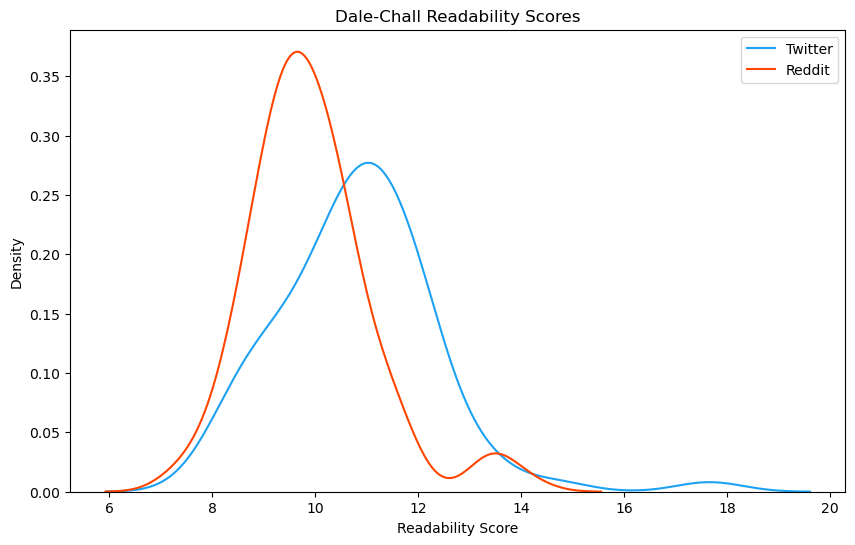

In [174]:

# Plot the two distributions
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(long_tweet_convos["readability_score"], ax=ax, label="Twitter", color=twitter_color)
sns.kdeplot(long_reddit_convos["readability_score"], ax=ax, label="Reddit", color=reddit_color)
ax.set_title("Dale-Chall Readability Scores")
ax.set_xlabel("Readability Score")
ax.set_ylabel("Density")
ax.legend()
plt.show()

# Step 4. Report any bivariate or multivariate comparisons
~~~
# Answer here.
~~~

In [107]:
import seaborn as sns

U-statistic: 6067.0
p-value: 0.0000005553


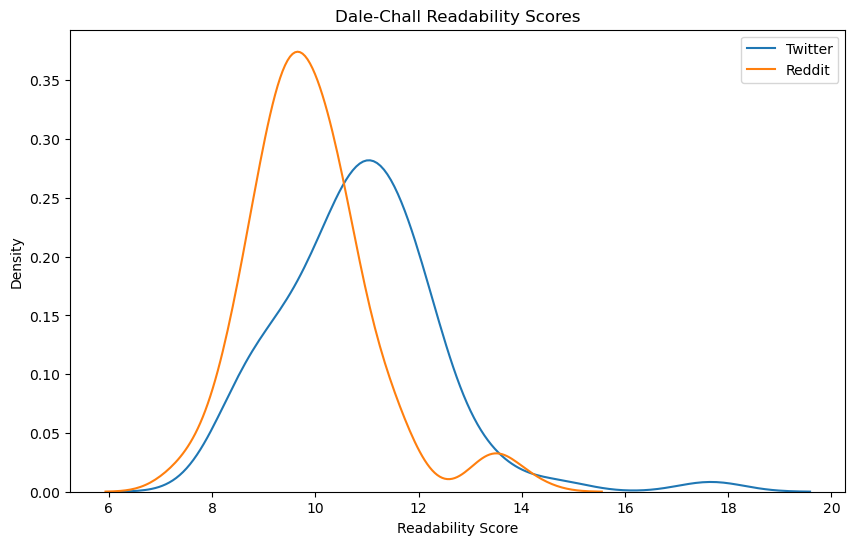

In [109]:
# import t test
import scipy.stats as stats

# run mann-whitney u test
t_test_result = stats.mannwhitneyu(tweet_convo["score"], reddit_convo_df["score"])

# report results
print(f"U-statistic: {t_test_result[0]}\np-value: {t_test_result[1]:.10f}")


Twitter correlation: -0.024 (p-value: 0.837)
Reddit correlation: 0.037 (p-value: 0.694)


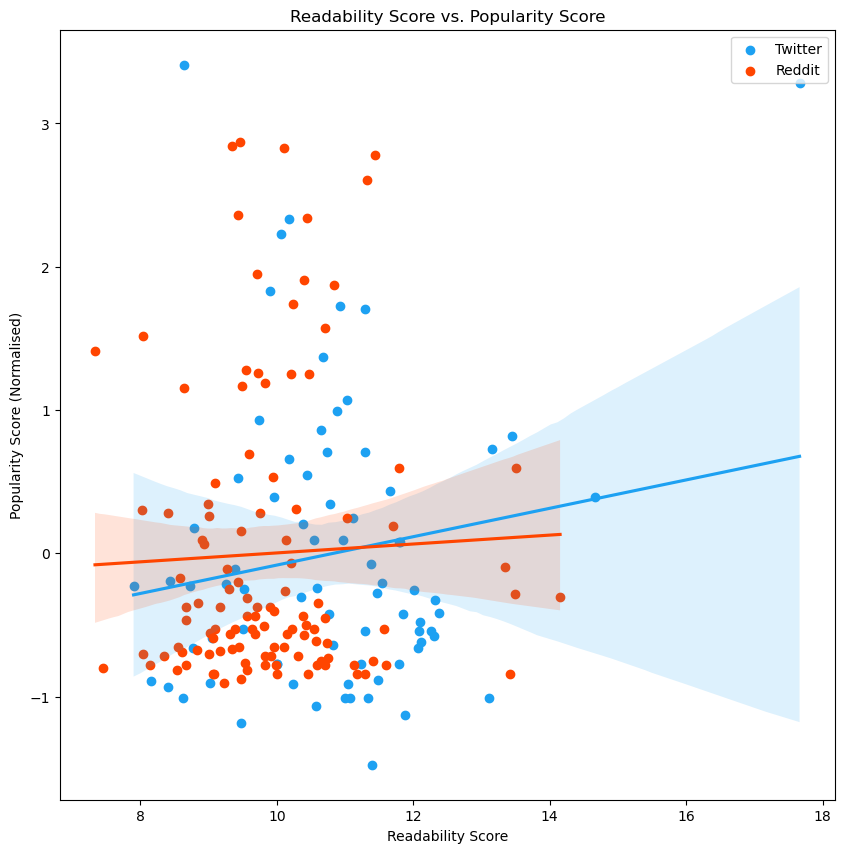

In [178]:
# calculate the correlation between readability score and popularity score
tweet_cor = stats.spearmanr(long_tweet_convos["readability_score"], long_tweet_convos["popularity_score"])
reddit_cor = stats.spearmanr(long_reddit_convos["readability_score"], long_reddit_convos["score"])

# report results
print(f"Twitter correlation: {tweet_cor[0]:.3f} (p-value: {tweet_cor[1]:.3f})")
print(f"Reddit correlation: {reddit_cor[0]:.3f} (p-value: {reddit_cor[1]:.3f})")


# plot scatter plot of readability score vs. popularity score
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(long_tweet_convos["readability_score"], long_tweet_convos["normalised_popularity"], label="Twitter", c=twitter_color)
ax.scatter(long_reddit_convos["readability_score"], long_reddit_convos["normalised_popularity"], label="Reddit", c=reddit_color)
# add regression lines with confidence intervals
sns.regplot(x="readability_score", y="normalised_popularity", data=long_tweet_convos, ax=ax, scatter=False, color=twitter_color)
sns.regplot(x="readability_score", y="normalised_popularity", data=long_reddit_convos, ax=ax, scatter=False, color=reddit_color)
ax.set_xlabel("Readability Score")
ax.set_ylabel("Popularity Score (Normalised)")
ax.set_title("Readability Score vs. Popularity Score")
ax.legend(loc="best")
plt.show()



SpearmanrResult(correlation=0.037288187304197674, pvalue=0.6936708949955073)

# Step 5. Reflect on findings in relation to setup
~~~
# Answer here.
~~~